Dealing with selection bias problem with FG model, as coaches only tend to kick FGs when it is optimal (unless forced in win situations). This is known as NMAR (not missing at random). To combat this, i applied the Heckman model.

In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_points,home_pregame_elo,away_id,away_team,away_conference,away_points,away_pregame_elo,home_division,away_division
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,17.0,1530.0,2335,Liberty,Big South,10.0,1467.0,fbs,fcs
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,27.0,1759.0,153,North Carolina,ACC,10.0,1638.0,fbs,fbs
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,31.0,NaN,2506,Presbyterian,Big South,7.0,NaN,fbs,fcs
3,332410084,2013,1,regular,True,False,3830.0,2013-08-29 23:00:00+00:00,84,Indiana,Big Ten,73.0,NaN,282,Indiana State,MVFC,35.0,NaN,fbs,fcs
4,332412413,2013,1,regular,True,False,3774.0,2013-08-29 23:00:00+00:00,2413,Morehead State,Pioneer,10.0,NaN,95,Pikeville,None,13.0,NaN,fcs,None


In [5]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        df_season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)

        df_tmp["start_time_minutes"] = df_tmp["start_time"].apply(lambda x: x["minutes"])
        df_tmp["start_time_seconds"] = df_tmp["start_time"].apply(lambda x: x["seconds"])
        df_tmp["end_time_minutes"] = df_tmp["end_time"].apply(lambda x: x["minutes"])
        df_tmp["end_time_seconds"] = df_tmp["end_time"].apply(lambda x: x["seconds"])
        df_tmp.drop(columns=["start_time","end_time"], inplace=True)

        df_season_drives = df_tmp.copy()
                
        df_season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(df_season_drives)
    
df_drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_drives.head()

Reading ../data/drives/2013.parquet from cached data
Reading ../data/drives/2014.parquet from cached data
Reading ../data/drives/2015.parquet from cached data
Reading ../data/drives/2016.parquet from cached data
Reading ../data/drives/2017.parquet from cached data
Reading ../data/drives/2018.parquet from cached data
Reading ../data/drives/2019.parquet from cached data
Reading ../data/drives/2020.parquet from cached data
Reading ../data/drives/2021.parquet from cached data
Reading ../data/drives/2022.parquet from cached data
Reading ../data/drives/2023.parquet from cached data
Reading ../data/drives/2024.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000601,1,False,1,25,75,1,36,64,6,11,PUNT,True,0,0,0,0,15,0,11,55
1,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000602,2,True,1,77,77,1,16,16,12,61,FG GOOD,False,0,0,3,0,11,55,5,52
2,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000603,3,False,1,48,52,1,76,24,9,28,FG MISSED,True,0,3,0,3,5,52,2,21
3,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000604,4,True,1,76,76,1,0,0,3,76,RUSHING TD,False,3,0,10,0,2,21,1,16
4,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000605,5,False,1,25,75,2,45,55,5,20,PUNT,True,0,10,0,10,1,16,14,53


In [6]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,332412579,2013,1,regular,2013-08-29 22:00:00+00:00,False,South Carolina,SEC,North Carolina,ACC,3994,Williams-Brice Stadium,93.9,71.8,49.0,0.0,0,340.0,0.0,1011.7,NaN,None
1,332410254,2013,1,regular,2013-08-30 00:00:00+00:00,False,Utah,Pac-12,Utah State,Mountain West,587,Rice-Eccles Stadium,95.0,46.2,19.0,0.0,0,320.0,0.0,1012.6,NaN,None
2,332422247,2013,1,regular,2013-08-30 23:00:00+00:00,False,Georgia State,Sun Belt,Samford,Southern,3495,Georgia Dome,82.9,73.8,74.0,0.0,0,40.0,0.0,1012.9,NaN,None
3,332430059,2013,1,regular,2013-08-31 16:00:00+00:00,False,Georgia Tech,ACC,Elon,Southern,721,Bobby Dodd Stadium,84.0,72.0,67.0,0.0,0,250.0,0.0,1014.0,NaN,None
4,332430277,2013,1,regular,2013-08-31 16:00:00+00:00,False,West Virginia,Big 12,William & Mary,CAA,3842,Milan Puskar Stadium,79.0,67.1,67.0,0.0,0,230.0,0.0,1012.0,NaN,None


In [7]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    df_venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    df_venues = pd.DataFrame([val.to_dict() for val in data])
    df_venues.columns = convert_to_snake_case(df_venues.columns)
    df_venues.to_parquet(file_path)

df_venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [8]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        df_season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = df_games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            df_tmp = pd.DataFrame([val.to_dict() for val in data])
            if df_tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            df_tmp.columns = convert_to_snake_case(df_tmp.columns)

            df_tmp['clock_minutes'] = df_tmp['clock'].apply(lambda x: x['minutes'])
            df_tmp['clock_seconds'] = df_tmp['clock'].apply(lambda x: x['seconds'])
            df_tmp.drop(columns=['clock'], inplace=True)

            df_tmp = df_tmp[cols]
            season_dfs.append(df_tmp)
        
        df_season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        df_season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, df_tmp

    all_dfs.append(df_season_plays)

    del df_season_plays
    
df_plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,season,week,season_type,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,2013,1,regular,332430120038,33243012007,332430120,7,1,Maryland,ACC,13,Florida International,Maryland,Florida International,Conference USA,3,1,2.0,3.0,40,60,1,10,2,False,Pass Completion,C.J. Brown pass complete to Dave Stinebaugh fo...,-0.679984,3,31
1,2013,1,regular,332430120044,33243012007,332430120,7,4,Maryland,ACC,13,Florida International,Maryland,Florida International,Conference USA,3,1,2.0,3.0,53,47,1,10,2,False,Rush,Brandon Ross rush for 2 yards to the FlaIn 45.,-0.583582,2,9
2,2013,1,regular,332430120047,33243012007,332430120,7,6,Maryland,ACC,13,Florida International,Maryland,Florida International,Conference USA,3,1,2.0,3.0,57,43,3,6,10,False,Pass Completion,C.J. Brown pass complete to Stefon Diggs for 1...,1.925720,1,9
3,2013,1,regular,332430120042,33243012007,332430120,7,3,Maryland,ACC,13,Florida International,Maryland,Florida International,Conference USA,3,1,2.0,3.0,49,51,3,1,4,False,Rush,C.J. Brown rush for 4 yards to the FlaIn 47 fo...,1.200877,2,44
4,2013,1,regular,332430120053,33243012007,332430120,7,10,Maryland,ACC,20,Florida International,Maryland,Florida International,Conference USA,3,2,2.0,3.0,35,65,-1,-1,0,False,Kickoff,Brad Craddock kickoff for 65 yards for a touch...,NaN,14,54


In [9]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos = df_elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
df_elos.head()

,season,week,season_type,team_id,team,division,elo
0,2013,1,regular,2,Auburn,fbs,2264.753528
1,2013,2,regular,2,Auburn,fbs,2254.767777
2,2013,3,regular,2,Auburn,fbs,2303.322874
3,2013,4,regular,2,Auburn,fbs,2344.906060
4,2013,6,regular,2,Auburn,fbs,2338.580248


## 2. Join and Filter the Data

In [10]:
df_drives.head()

,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000601,1,False,1,25,75,1,36,64,6,11,PUNT,True,0,0,0,0,15,0,11,55
1,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000602,2,True,1,77,77,1,16,16,12,61,FG GOOD,False,0,0,3,0,11,55,5,52
2,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000603,3,False,1,48,52,1,76,24,9,28,FG MISSED,True,0,3,0,3,5,52,2,21
3,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000604,4,True,1,76,76,1,0,0,3,76,RUSHING TD,False,3,0,10,0,2,21,1,16
4,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000605,5,False,1,25,75,2,45,55,5,20,PUNT,True,0,10,0,10,1,16,14,53


In [11]:
play_cols = [
    'game_id','drive_id','id','offense','period','clock_minutes','clock_seconds',
    'offense_score','defense_score', 'offense_timeouts','defense_timeouts',
    'yards_to_goal','down','distance', 'play_type','play_text'
]
game_cols = [
    'season','week','id','season_type','neutral_site','venue_id', 'completed',
    'home_id','home_team','home_conference',
    'away_id','away_team','away_conference',
]
drive_cols = [
    'game_id', 'id', 'drive_result', 'start_offense_score', 'end_offense_score',
]
venue_cols = [
    'id', 'elevation', 'grass'
]
elo_cols = ['season', 'week', 'division', 'team_id', 'elo']
weather_cols = [
    'id','precipitation','wind_speed','temperature','game_indoors'
]

df = (
    df_plays[play_cols].rename(columns={'id':'play_id'})
    .query('down==4')
    .assign(
        clock_minutes=lambda x: np.maximum(np.minimum(x['clock_minutes'], 15), 0),
        clock_seconds=lambda x: np.maximum(np.minimum(x['clock_seconds'], 59), 0),
        offense_score=lambda x: np.maximum(x['offense_score'], 0),
        defense_score=lambda x: np.maximum(x['defense_score'], 0),
    )
    .assign(
        pct_game_played=lambda x: np.where(
            x.period > 4,
            .99, # default to 99% for OT
            (((x['period'] - 1) * 15 * 60) + (15* 60) - 
                (x['clock_minutes'] * 60 + x['clock_seconds'])
                ) / (15 * 60 * 4)
        ),
        score_diff=lambda x: x['offense_score'] - x['defense_score'],
    )
    .query('0 < period')
    .query('0 <= yards_to_goal <= 100')
    .query('0 <= distance <= 100')
    .drop(columns=['clock_minutes','clock_seconds'])
    .merge(
        df_drives[drive_cols].rename(columns={'id':'drive_id'}),
        how='left',
        on=['game_id', 'drive_id']
    )
    .assign(
        drive_pts_scored=lambda x: x['end_offense_score'] - x['start_offense_score'],
    )
    .merge(
        df_games[game_cols].rename(columns={'id':'game_id'}),
        how='left',
        on=['game_id']
    )
    .query('completed == True')
    .assign(
        is_home_team=lambda x: np.select([x.neutral_site, x.offense == x.home_team],[0, 1], default=-1),
    )
    .merge(
        df_venues[venue_cols].rename(columns={'id':'venue_id'}),
        how='left',
        on=['venue_id']
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 
                                          'division': 'home_division', 
                                          'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 
                                          'division': 'away_division', 
                                          'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
    .assign(
        pregame_elo_diff=lambda x: np.where(
            x.offense == x.home_team,
            x.home_pregame_elo - x.away_pregame_elo,
            x.away_pregame_elo - x.home_pregame_elo
        ),
        pregame_offense_elo=lambda x: np.where(
            x.offense == x.home_team,
            x.home_pregame_elo,
            x.away_pregame_elo
        ),
        pregame_defense_elo=lambda x: np.where(
            x.offense == x.home_team,
            x.away_pregame_elo,
            x.home_pregame_elo
        ),
    )
    .merge(
        df_weather[weather_cols].rename(columns={'id':'game_id'}),
        how='left',
        on=['game_id']
    )
    .assign(
        distance=lambda x: np.where(
            x.yards_to_goal - x.distance < 0,
            x.yards_to_goal,
            x.distance
        )
    )
    .assign(
        game_seconds_remaining = lambda x: 3600 - (x.pct_game_played * 60 * 15 * 4).astype(int),
    )
)

df['pressure_rating'] = np.select(
    [
         # tie or take the lead, last 2 min or OT
        (
            ((df['game_seconds_remaining'] <= 120) | (df['period'] > 4)) & 
            (df['score_diff'] >= -3) & (df['score_diff'] <= 0)
        ), 

        # (tie or take the lead, last 5 - 2 min) or (stay within one score, last 2 min)
        (
            ((df['game_seconds_remaining'] <= 300) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0)) |
            ((df['game_seconds_remaining'] <= 120) & (df['score_diff'] >= -11) & (df['score_diff'] <= -4))
        ),

         # (tie or take the lead, last 10 - 5 min) or (stay within one score, last 5 min)
        (
            ((df['game_seconds_remaining'] <= 600) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0)) |
            ((df['game_seconds_remaining'] <= 300) & (df['score_diff'] >= -11) & (df['score_diff'] <= -4))
        ),

        # (tie or take the lead, last 15 - 10 min) or (stay within one score, last 10 min)
        (
            ((df['game_seconds_remaining'] <= 900) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0)) |
            ((df['game_seconds_remaining'] <= 600) & (df['score_diff'] >= -11) & (df['score_diff'] <= -4))
        ),

        # stay within one score, last 15 min
        (
            (df['game_seconds_remaining'] <= 900) & (df['score_diff'] >= -11) & (df['score_diff'] <= -4)
        )
    ],
    [4, 3, 2, 1, 0.5],
    default=0
)

df = df.assign(
    offense_division = np.where(df['offense'] == df['home_team'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home_team'], df['away_division'], df['home_division']),
    grass = df.grass.fillna(False),
    game_indoors = df.game_indoors.fillna(False)
)
df = df.assign(
    temperature = np.where(df.game_indoors, 70, df.temperature.fillna(int(df.temperature.mean()))),
    wind_speed = np.where(df.game_indoors, 0, df.wind_speed.fillna(int(df.wind_speed.mean()))),
    elevation = df.elevation.fillna(int(df.elevation.astype(float).mean())),
    precipitation = np.where(df.game_indoors, 0, df.precipitation.fillna(int(df.precipitation.mean()))),
    defense_timeouts = np.minimum(np.maximum(df.defense_timeouts, 0), 3),
    offense_timeouts = np.minimum(np.maximum(df.offense_timeouts, 0), 3),
)
df['elevation'] = df['elevation'].astype(float)    

df.head()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24454/1329404312.py:153: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grass = df.grass.fillna(False),
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24454/1329404312.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_indoors = df.game_indoors.fillna(False)


,game_id,drive_id,play_id,offense,period,offense_score,defense_score,offense_timeouts,defense_timeouts,yards_to_goal,down,distance,play_type,play_text,pct_game_played,score_diff,drive_result,start_offense_score,end_offense_score,drive_pts_scored,season,week,season_type,neutral_site,venue_id,completed,home_id,home_team,home_conference,away_id,away_team,away_conference,is_home_team,elevation,grass,home_division,home_pregame_elo,away_division,away_pregame_elo,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,precipitation,wind_speed,temperature,game_indoors,game_seconds_remaining,pressure_rating,offense_division,defense_division
0,332430120,33243012019,332430120169,Maryland,3,40,10,3.0,3.0,60,4,5,Punt,"Nathan Renfro punt for 35 yards, returned by S...",0.569167,30,PUNT,40,40,0,2013,1,regular,False,3665.0,True,120,Maryland,ACC,2229,Florida International,Conference USA,1,32.687481,False,fbs,1919.582722,fbs,1387.503336,532.079386,1919.582722,1387.503336,0.0,4.7,87.4,False,1551,0.0,fbs,fbs
1,332430120,33243012021,332430120187,Maryland,3,40,10,3.0,3.0,24,4,2,Rush,Brandon Ross rush for no gain to the FlaIn 24.,0.634444,30,TURNOVER ON DOWNS,40,40,0,2013,1,regular,False,3665.0,True,120,Maryland,ACC,2229,Florida International,Conference USA,1,32.687481,False,fbs,1919.582722,fbs,1387.503336,532.079386,1919.582722,1387.503336,0.0,4.7,87.4,False,1316,0.0,fbs,fbs
2,332430120,33243012023,332430120204,Maryland,3,40,10,3.0,3.0,52,4,23,Punt,"Nathan Renfro punt for 41 yards, returned by S...",0.666389,30,PUNT,40,40,0,2013,1,regular,False,3665.0,True,120,Maryland,ACC,2229,Florida International,Conference USA,1,32.687481,False,fbs,1919.582722,fbs,1387.503336,532.079386,1919.582722,1387.503336,0.0,4.7,87.4,False,1201,0.0,fbs,fbs
3,332430120,33243012025,332430120241,Maryland,4,43,10,3.0,3.0,5,4,5,Field Goal Good,Brad Craddock 23 yard field goal GOOD.,0.788889,33,FG GOOD,40,43,3,2013,1,regular,False,3665.0,True,120,Maryland,ACC,2229,Florida International,Conference USA,1,32.687481,False,fbs,1919.582722,fbs,1387.503336,532.079386,1919.582722,1387.503336,0.0,4.7,87.4,False,761,0.0,fbs,fbs
4,332430120,33243012027,332430120271,Maryland,4,43,10,2.0,3.0,76,4,15,Punt,"Nathan Renfro punt for 37 yards, fair catch by...",0.898611,33,PUNT,43,43,0,2013,1,regular,False,3665.0,True,120,Maryland,ACC,2229,Florida International,Conference USA,1,32.687481,False,fbs,1919.582722,fbs,1387.503336,532.079386,1919.582722,1387.503336,0.0,4.7,87.4,False,365,0.0,fbs,fbs


In [12]:
rush = (
    df['play_text'].str.contains('rush', case=False) |
    df['play_text'].str.contains('run', case=False) |
    df['play_text'].str.contains('scramble', case=False) |
    (df['play_type'] == 'Rush')
)
pass_ = (
    df['play_text'].str.contains('pass', case=False) |
    df['play_text'].str.contains('throw', case=False) |
    df['play_text'].str.contains('sack', case=False) |
    df['play_text'].str.contains('intercept', case=False) |
    (df['play_type'].str.contains('Pass', case=False)) |
    (df['play_type'].str.contains('Sack', case=False)) 
)
punt = (
    df['play_text'].str.contains('punt', case=False) |
    df['play_type'].str.contains('Punt', case=False) | 
    (df.play_type == 'Punt')
)
field_goal = (
    df['play_text'].str.contains('field goal', case=False) |
    df['play_text'].str.contains('fg', case=False) |
    df['play_type'].str.contains('Field Goal', case=False)
)
penalty = (
    df['play_text'].str.contains('penalty', case=False) |
    df['play_type'].str.contains('Penalty', case=False) |
    df['play_text'].str.contains('illegal', case=False) |
    df['play_text'].str.contains('offside', case=False) |
    df['play_text'].str.contains('false start', case=False) |
    df['play_text'].str.contains('delay of game', case=False) |
    df['play_text'].str.contains('pass interference', case=False) |
    df['play_text'].str.contains('holding', case=False) |
    df['play_text'].str.contains('personal foul', case=False) |
    df['play_text'].str.contains('roughing', case=False) |
    df['play_text'].str.contains('unsportsmanlike', case=False) |
    df['play_text'].str.contains('taunting', case=False)
)
kneel = (
    df['play_text'].str.contains('kneel', case=False) |
    df['play_type'].str.contains('Kneel', case=False)
)
timeout = (
    df['play_text'].str.contains('timeout', case=False) |
    df['play_type'].str.contains('Timeout', case=False)
)
kickoff = (
    df['play_text'].str.contains('kickoff', case=False) |
    df['play_type'].str.contains('Kickoff', case=False)
)
end_of_period = (
    df['play_text'].str.contains('end ', case=False) |
    df['play_type'].str.contains('end ', case=False)
)
safety = (
    df['play_text'].str.contains('safety', case=False) |
    df['play_type'].str.contains('Safety', case=False)
)

df = df.assign(
    action=np.select(
        [
            penalty, end_of_period, timeout, kneel, kickoff,  field_goal, punt, rush, pass_, 
            safety
        ],
        [
            'penalty', 'end_of_period', 'timeout', 'kneel', 'kickoff', 'field_goal', 'punt', 'rush', 
            'pass', 'safety'
        ],
        default='other'
    )
)

drop_actions = [
    'penalty', 'timeout', 'kickoff', 'end_of_period', 'safety', 'kneel', 'other'
]
df = df.query('action not in @drop_actions').reset_index(drop=True)

df['decision'] = np.select(
    [
        df['action'].isin(['rush', 'pass']),
        df['action'] == 'punt',
        df['action'] == 'field_goal'
    ],
    [
        'go', 'punt', 'field_goal'
    ],
    default=-1
)

df = df.assign(
    grass = df.grass.astype(int),
    game_indoors = df.game_indoors.astype(int),
)

df.action.value_counts()

action
punt          108348
field_goal     33194
pass           20725
rush           20108
Name: count, dtype: int64

In [13]:
df['kick_distance'] = df.yards_to_goal + 17  # 7 yards snap + 10 yards endzone

In [14]:
# Assume teams only kick 60 yard field goals (removing the several erroneous 65+ yard attempts)
df = df.query('kick_distance <= 65').reset_index(drop=True)

# Only FBS FG kicks
df = df.query('offense_division == "fbs"').reset_index(drop=True)

In [15]:
df.decision.value_counts()

decision
field_goal    27495
go            24290
punt          12879
Name: count, dtype: int64

In [16]:
df['play_text'] = df['play_text'].fillna('')

df['fg_attempt'] = np.where(
    df['decision'] == 'field_goal',
    1,
    0
)
df['fg_make'] = np.where(
    ((df['action'] == 'field_goal') & 
     ((df['play_type'] == 'Field Goal Good') | 
      ((df.play_text.str.contains('good', case=False) & ~df.play_text.str.contains('no good', case=False) & ~df.play_text.str.contains('missed', case=False))))),
    1,
    0
)
# df['fg_make'] = np.where(
#     ((df['action'] == 'field_goal') & 
#      (df['drive_pts_scored'] == 3)),
#     1,
#     0
# )

In [17]:
df.query('fg_attempt==1').fg_make.value_counts(normalize=True)

fg_make
1    0.750973
0    0.249027
Name: proportion, dtype: float64

## 3. Aww Heck Man Model

#### i. Selection Model (Probit)

In [20]:
selection_features = [
    'yards_to_goal', 'score_diff', 'pct_game_played', 'pregame_offense_elo', 
    'pregame_defense_elo', 'distance', 'is_home_team',
    'wind_speed', 'temperature',
    'elevation', 'grass', 'game_indoors'
]
X_sel = df[selection_features].copy()
X_sel = sm.add_constant(X_sel)
y_sel = df['fg_attempt']

selection_model = sm.Probit(y_sel, X_sel).fit()
df['probit_score'] = selection_model.predict(X_sel)

Optimization terminated successfully.
         Current function value: 0.464998
         Iterations 6


In [21]:
print(selection_model.summary())

                          Probit Regression Results                           
Dep. Variable:             fg_attempt   No. Observations:                64664
Model:                         Probit   Df Residuals:                    64651
Method:                           MLE   Df Model:                           12
Date:                Sun, 28 Sep 2025   Pseudo R-squ.:                  0.3181
Time:                        18:28:40   Log-Likelihood:                -30069.
converged:                       True   LL-Null:                       -44095.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6944      0.045     15.478      0.000       0.606       0.782
yards_to_goal          -0.0690      0.001   -135.346      0.000      -0.070      -0.068
score_diff      

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature 
# 1-2 VIF means no multicollinearity
# 2-5 VIF means moderate multicollinearity
# >5 VIF means high multicollinearity)
vif_data = pd.DataFrame()
vif_data['feature'] = X_sel.columns
vif_data['VIF'] = [variance_inflation_factor(X_sel.values, i) for i in range(X_sel.shape[1])]

print(vif_data)

                feature        VIF
0                 const  59.476940
1         yards_to_goal   1.060888
2            score_diff   1.326482
3       pct_game_played   1.003794
4   pregame_offense_elo   1.441302
5   pregame_defense_elo   1.524156
6              distance   1.053715
7          is_home_team   1.052159
8            wind_speed   1.109497
9           temperature   1.049408
10            elevation   1.031319
11                grass   1.180846
12         game_indoors   1.130097


#### ii. Compute Inverse Mills Ratio

In [23]:
# Only apply to rows where FG was attempted
attempts = df['fg_attempt'] == 1
W_gamma = df.loc[attempts, 'probit_score']

# Inverse Mills Ratio λ = φ / Φ
phi = norm.pdf(W_gamma)
Phi = norm.cdf(W_gamma)
df.loc[attempts, 'lambda'] = phi / Phi

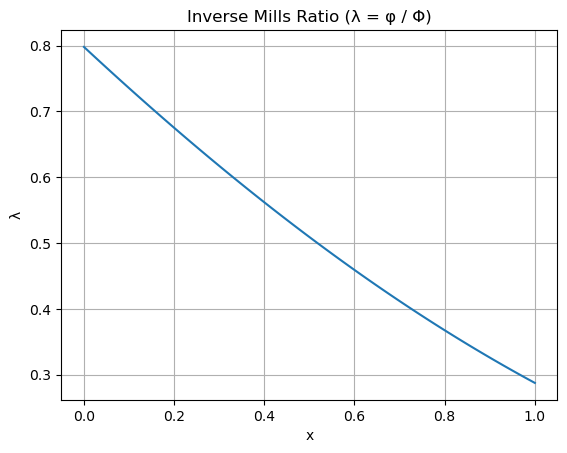

In [24]:
# plot phi/Phi
x = np.linspace(0, 1, 100)
y = norm.pdf(x) / norm.cdf(x)
plt.plot(x, y)
plt.title('Inverse Mills Ratio (λ = φ / Φ)')
plt.xlabel('x')
plt.ylabel('λ')
plt.grid()
plt.show()

#### iii. Fit the Outcome FG Model

In [42]:
df['yards_to_goal_squared'] = df['yards_to_goal'] ** 2

In [73]:
# Features for outcome model
outcome_features = [
    'season',
    'yards_to_goal_squared',  
    'pregame_offense_elo', 
    'pregame_defense_elo',
    'pressure_rating',
    'wind_speed', 
    'elevation', 
    'lambda'
]

X_out = df.loc[attempts, outcome_features].copy()
X_out = sm.add_constant(X_out)
y_out = df.loc[attempts, 'fg_make']

# Probit model
outcome_model = sm.Probit(y_out, X_out).fit()
print(outcome_model.summary())

Optimization terminated successfully.
         Current function value: 0.503204
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                fg_make   No. Observations:                27495
Model:                         Probit   Df Residuals:                    27486
Method:                           MLE   Df Model:                            8
Date:                Sun, 28 Sep 2025   Pseudo R-squ.:                  0.1034
Time:                        18:39:56   Log-Likelihood:                -13836.
converged:                       True   LL-Null:                       -15432.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -30.5751      4.997     -6.119      0.000     -40.368     -20.

In [74]:
vals =  {
    "const": 1,
    "season": 2015,
    "yards_to_goal": 45**2, # 62 yard fg
    # "score_diff": 0,
    "pregame_offense_elo": 2868.2571287269125,
    "pregame_defense_elo": 3485.8178804883173,
    "pressure_rating": 0,
    "wind_speed": 0.0,
    "elevation": 172.5047302,
    "lambda": 0.7281473913286698
  }

X_new = pd.DataFrame([vals])
outcome_model.predict(X_new).values[0]

0.12784794640986458

In [75]:
df['pred_make_prob_probit'] = np.nan
df.loc[attempts, 'pred_make_prob_probit'] = outcome_model.predict(X_out)

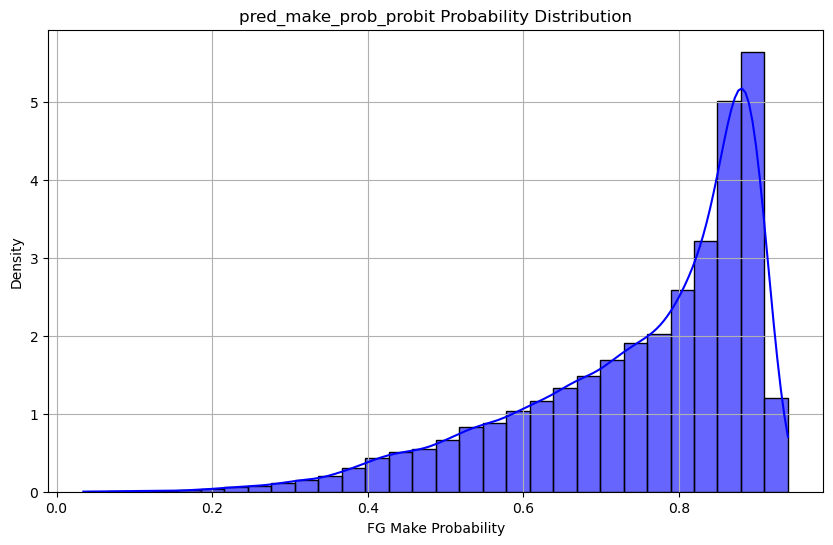

In [76]:
# plot win probability
def plot_wp(df, col='fg_proba_50'):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True, stat='density', color='blue', alpha=0.6)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('FG Make Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(df, col='pred_make_prob_probit')

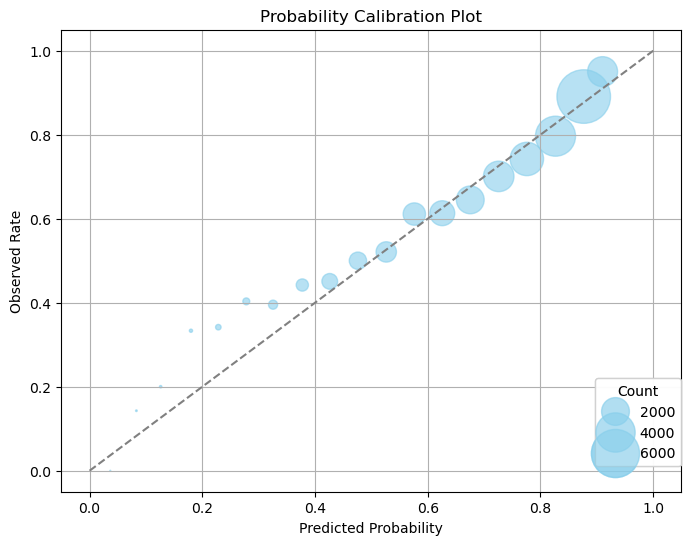

In [77]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        calibration['predicted_proba'], 
        calibration['actual_proba'], 
        s=calibration['count'] * scale,
        alpha=0.6, 
        label='Calibration Curve',
        color='skyblue',
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()

    # Add legend for dot size reference
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4, func=lambda x: x / scale,
                                              color='skyblue')
    labels = [int(re.search(r'\{(\d+)\}', value).group(1)) for value in labels]
    legend = plt.legend(handles, labels, title="Count", loc="center left", bbox_to_anchor=(.85, 0.15))
    plt.gca().add_artist(legend)

    plt.show()

plot_calibration(df, proba_col='pred_make_prob_probit', actual_col='fg_make', bins=20)

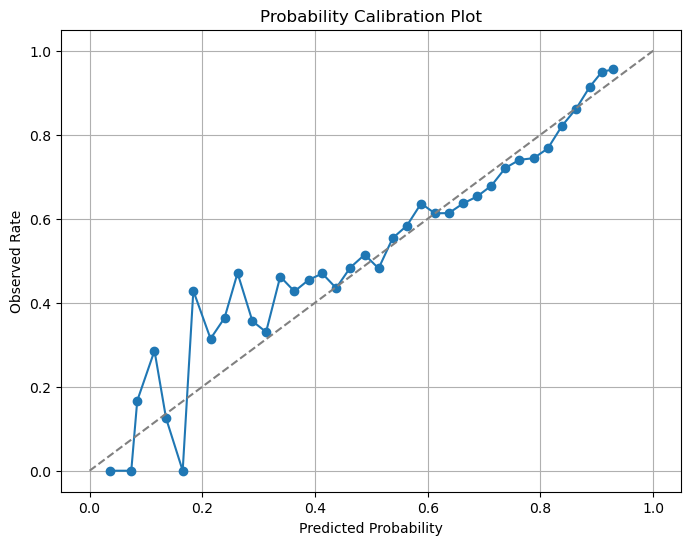

In [78]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(df, proba_col='pred_make_prob_probit', actual_col='fg_make', bins=40)

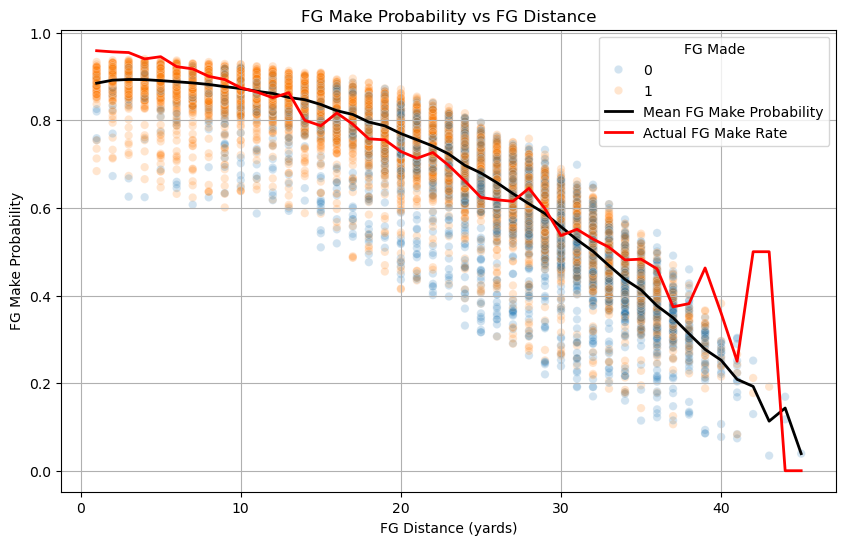

In [79]:
# plot pred_make_prob_probit vs fg_distance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='yards_to_goal', y='pred_make_prob_probit', hue='fg_make', alpha=0.2)
# plot the mean pred_make_prob_probit for each yards_to_goal
mean_fg_proba = df.groupby('yards_to_goal')['pred_make_prob_probit'].mean().reset_index()
plt.plot(mean_fg_proba['yards_to_goal'], mean_fg_proba['pred_make_prob_probit'], color='black', linewidth=2, label='Mean FG Make Probability')
# plot the actual fg_make rate for each yards_to_goal
actual_fg_rate = df.query('fg_attempt==1').groupby('yards_to_goal')['fg_make'].mean().reset_index()
plt.plot(actual_fg_rate['yards_to_goal'], actual_fg_rate['fg_make'], color='red', linewidth=2, label='Actual FG Make Rate')
plt.title('FG Make Probability vs FG Distance')
plt.xlabel('FG Distance (yards)')
plt.ylabel('FG Make Probability')
plt.grid()
plt.legend(title='FG Made', loc='upper right')
plt.show()

## 6. Save the models

In [80]:
model_dir = join('..', '..', 'inference', 'models', 'fg_probability')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

selection_model.save(join(model_dir, 'selection_model.pkl'))
outcome_model.save(join(model_dir, 'outcome_model.pkl'))